## Importing packages and libraries

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (12, 5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available:", device)


Device available: cuda


In [2]:
# Load the HDF5 file
file_path = "/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5"
f = h5py.File(file_path, 'r')

# Show available keys in the HDF5 file
print("Keys in the dataset:", list(f.keys()))

# Load and transpose signal data (samples, 1024, 2) → (samples, 2, 1024)
X = np.transpose(f['X'][:], (0, 2, 1))

# Load label indices (0–10): these are int64 modulation IDs
Y = f['Y'][:].astype(int).squeeze()

# Optional: Load SNR or meta info (Z)
Z = f['Z'][:]

# Print shapes
print("Shapes:")
print("X (IQ samples):", X.shape)     # (samples, 2, 1024)
print("Y (modulation labels):", Y.shape)  # (samples,)
print("Z (SNR info):", Z.shape)


Keys in the dataset: ['X', 'Y', 'Z']
Shapes:
X (IQ samples): (2555904, 2, 1024)
Y (modulation labels): (2555904, 24)
Z (SNR info): (2555904, 1)


In [3]:
print("Shape of Y:", Y.shape)

print("Example Y[0]:", Y[0])
print("Unique values in Y:", np.unique(Y))

row_sums = np.sum(Y, axis=1)
print("First 5 row sums:", row_sums[:5])
print("All rows one-hot encoded?", np.all(row_sums == 1))

Y_ids = np.argmax(Y, axis=1)
print("Unique class IDs (from argmax):", np.unique(Y_ids))
print("Number of unique classes:", len(np.unique(Y_ids)))


Shape of Y: (2555904, 24)
Example Y[0]: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Unique values in Y: [0 1]
First 5 row sums: [1 1 1 1 1]
All rows one-hot encoded? True
Unique class IDs (from argmax): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Number of unique classes: 24


In [4]:
# Convert one-hot encoded Y to class IDs
Y_ids = np.argmax(Y, axis=1)  # shape: (2555904,)

# Count unique labels
print("Total unique classes:", len(np.unique(Y_ids)))
print("Class IDs:", np.unique(Y_ids))


Total unique classes: 24
Class IDs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


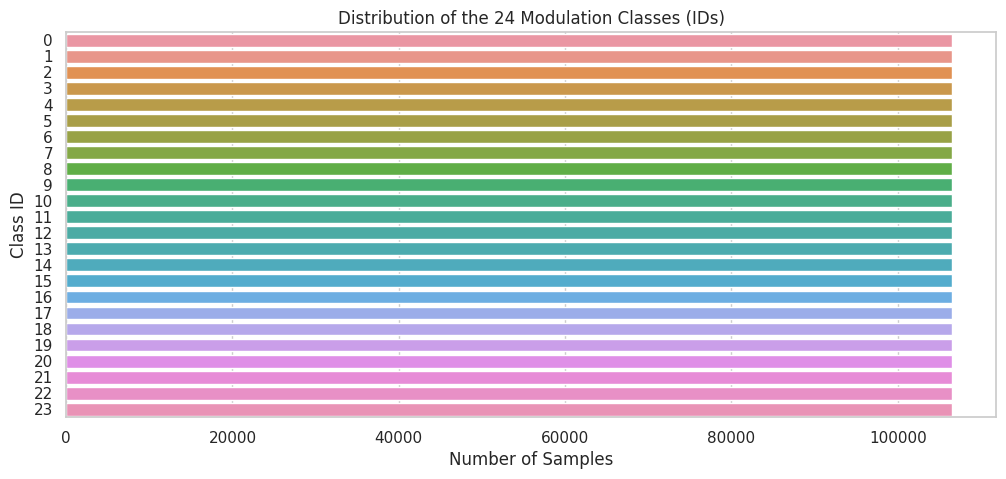

In [5]:
# Plot label counts
label_counts = pd.DataFrame({'Label': Y_ids})
sns.countplot(data=label_counts, y='Label', order=label_counts['Label'].value_counts().index)
plt.title("Distribution of the 24 Modulation Classes (IDs)")
plt.xlabel("Number of Samples")
plt.ylabel("Class ID")
plt.show()


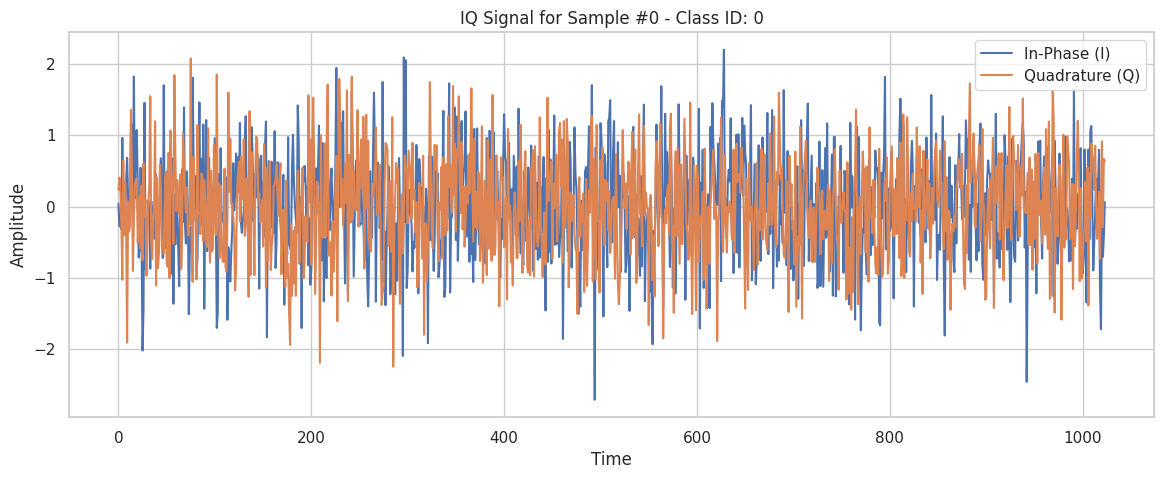

In [6]:
# Choose a sample index and get the signal
sample_index = 0
sample_iq = X[sample_index]
sample_label = Y_ids[sample_index]

# Plot In-Phase and Quadrature parts
plt.figure(figsize=(14, 5))
plt.plot(sample_iq[0], label='In-Phase (I)')
plt.plot(sample_iq[1], label='Quadrature (Q)')
plt.title(f"IQ Signal for Sample #{sample_index} - Class ID: {sample_label}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


## Splitting dataset for testing and training

In [7]:
# Use only a subset of the full dataset
N_SAMPLES = 300000
X_subset = X[:N_SAMPLES]
Y_subset = Y[:N_SAMPLES]  # shape: (samples, 24)

# Convert one-hot Y to class indices (for stratified sampling)
Y_class_ids = np.argmax(Y_subset, axis=1)

# ✅ Train/Test split (80/20) with class balance
X_train, X_test, Y_train, Y_test = train_test_split(
    X_subset, Y_subset, test_size=0.2, random_state=42, stratify=Y_class_ids
)

# Normalize inputs globally
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Multi-task Dataset class
class MultiTaskDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Dataloaders
train_dataset = MultiTaskDataset(X_train, Y_train)
test_dataset = MultiTaskDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

print("Data ready for training. Train samples:", len(train_dataset), "| Test samples:", len(test_dataset))


Data ready for training. Train samples: 240000 | Test samples: 60000


## Multi Task CNN Model

In [8]:
class MultiTaskIQCNN(nn.Module):
    def __init__(self, num_tasks=24):
        super(MultiTaskIQCNN, self).__init__()
        self.shared = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),

            nn.Flatten()
        )
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_tasks),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.shared(x)
        return self.head(features)

model = MultiTaskIQCNN(num_tasks=24).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Train and Evaluation functions
def train(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch)
        loss = loss_fn(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, Y_batch)

            preds = (outputs > 0.5).float()
            correct += (preds == Y_batch).sum().item()
            total += torch.numel(Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset), correct / total

train_losses = []
val_losses = []
val_accuracies = []

EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1/10
   Train Loss: 0.0510
   Val   Loss: 0.0415, Accuracy: 0.9793
Epoch 2/10
   Train Loss: 0.0442
   Val   Loss: 0.0390, Accuracy: 0.9804
Epoch 3/10
   Train Loss: 0.0405
   Val   Loss: 0.0373, Accuracy: 0.9811
Epoch 4/10
   Train Loss: 0.0384
   Val   Loss: 0.0361, Accuracy: 0.9815
Epoch 5/10
   Train Loss: 0.0376
   Val   Loss: 0.0351, Accuracy: 0.9819
Epoch 6/10
   Train Loss: 0.0369
   Val   Loss: 0.0348, Accuracy: 0.9820
Epoch 7/10
   Train Loss: 0.0364
   Val   Loss: 0.0351, Accuracy: 0.9819
Epoch 8/10
   Train Loss: 0.0359
   Val   Loss: 0.0349, Accuracy: 0.9820
Epoch 9/10
   Train Loss: 0.0354
   Val   Loss: 0.0343, Accuracy: 0.9823
Epoch 10/10
   Train Loss: 0.0352
   Val   Loss: 0.0338, Accuracy: 0.9825


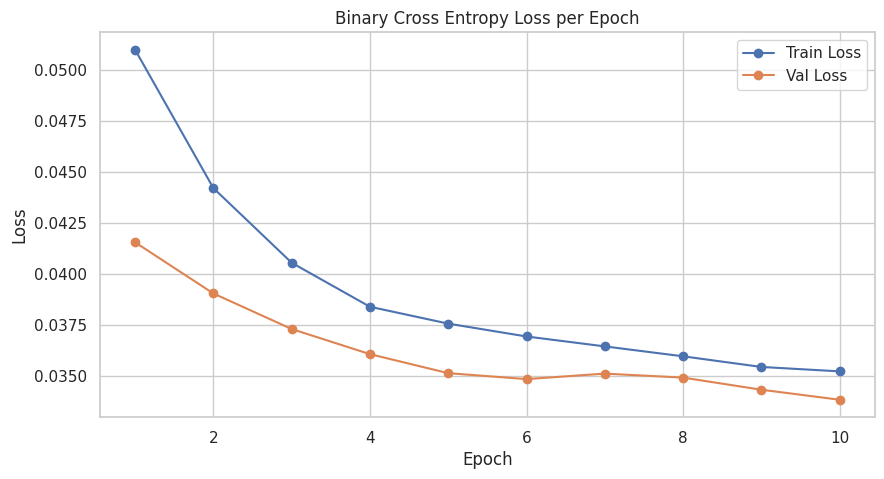

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, EPOCHS+1), val_losses, label="Val Loss", marker='o')
plt.title("Binary Cross Entropy Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


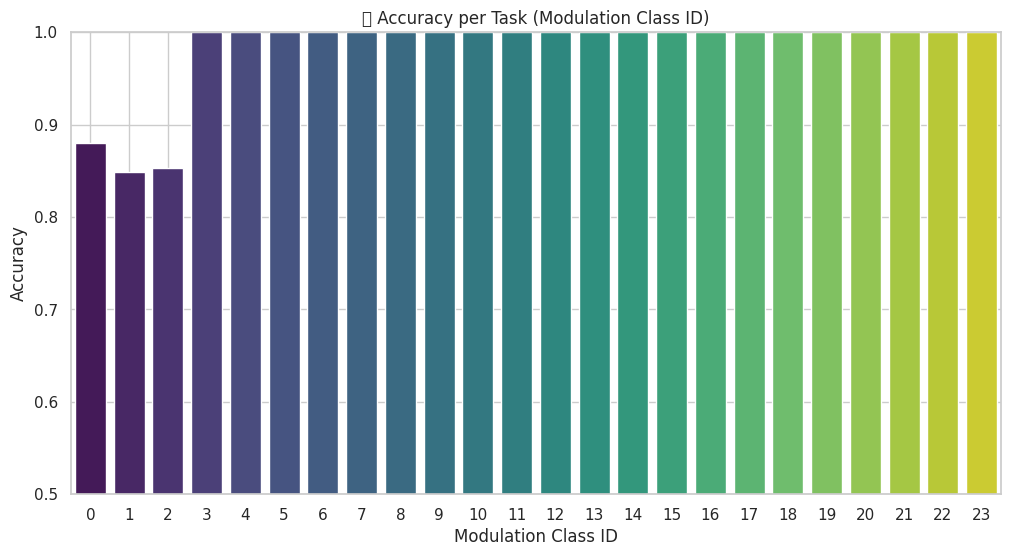

In [10]:
# Store per-task stats
num_tasks = 24
correct = [0] * num_tasks
total = [0] * num_tasks

# Go through test set
model.eval()
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        outputs = model(X_batch)
        preds = (outputs > 0.5).float()

        for i in range(num_tasks):
            correct[i] += (preds[:, i] == Y_batch[:, i]).sum().item()
            total[i] += Y_batch.shape[0]

# Calculate accuracy per task
task_accuracies = [c / t for c, t in zip(correct, total)]

# Visualize
df = pd.DataFrame({
    'Task ID': list(range(num_tasks)),
    'Accuracy': task_accuracies
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Task ID', y='Accuracy', palette="viridis")
plt.title("🔍 Accuracy per Task (Modulation Class ID)")
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.xlabel("Modulation Class ID")
plt.grid(True)
plt.show()


In [11]:
import random
from collections import defaultdict
import numpy as np

NUM_DEVICES = 5        # total simulated devices
K_CLASSES = 6          # number of modulation classes seen per device
TOTAL_CLASSES = 24     # total modulation classes

# Assign each device K unique modulation classes (tasks)
device_class_map = {}
all_class_ids = list(range(TOTAL_CLASSES))

for device_id in range(NUM_DEVICES):
    device_classes = random.sample(all_class_ids, K_CLASSES)
    device_class_map[device_id] = device_classes

print("✅ Assigned classes to each device:")
for d, cls in device_class_map.items():
    print(f"Device {d}: {cls}")


✅ Assigned classes to each device:
Device 0: [10, 23, 0, 3, 8, 2]
Device 1: [11, 6, 19, 17, 5, 21]
Device 2: [0, 13, 5, 2, 15, 18]
Device 3: [2, 19, 23, 0, 9, 8]
Device 4: [15, 16, 18, 10, 8, 4]


In [12]:
device_datasets = defaultdict(list)

# Go through the subset you already selected earlier (300K samples)
for i in range(len(Y_subset)):
    label_vector = Y_subset[i]
    class_index = np.argmax(label_vector)
    
    for device_id, allowed_classes in device_class_map.items():
        if class_index in allowed_classes:
            device_datasets[device_id].append((X_subset[i], label_vector))


In [13]:
class MultiTaskDeviceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data  
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


device_loaders = {}

for device_id in range(NUM_DEVICES):
    data = device_datasets[device_id]

    if len(data) < 100:  # too few samples — skip
        print(f"Device {device_id} has only {len(data)} samples — skipping.")
        continue

    random.shuffle(data)
    split = int(0.8 * len(data))
    train_data = data[:split]
    val_data = data[split:]

    train_loader = DataLoader(MultiTaskDeviceDataset(train_data), batch_size=128, shuffle=True)
    val_loader = DataLoader(MultiTaskDeviceDataset(val_data), batch_size=128)

    device_loaders[device_id] = (train_loader, val_loader)
    print(f" Device {device_id}: {len(train_data)} train | {len(val_data)} val samples")


 Device 0: 154803 train | 38701 val samples
Device 1 has only 0 samples — skipping.
 Device 2: 154803 train | 38701 val samples
 Device 3: 154803 train | 38701 val samples
Device 4 has only 0 samples — skipping.


## Compute Binary Cross Entropy only for selected output heads.

In [14]:
def masked_bce_loss(outputs, targets, visible_classes):
    
    mask = torch.zeros_like(targets)
    mask[:, visible_classes] = 1.0

    # Apply BCE only where mask == 1
    bce = nn.BCELoss(reduction='none')
    losses = bce(outputs, targets)

    masked_loss = (losses * mask).sum() / mask.sum()
    return masked_loss


In [15]:
def train_device_model(device_id, train_loader, val_loader, allowed_classes, epochs=5):
    print(f"\n Training model for Device {device_id} (Classes: {allowed_classes})")

    model = MultiTaskIQCNN(num_tasks=24).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            outputs = model(X_batch)
            loss = masked_bce_loss(outputs, Y_batch, allowed_classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        total_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = masked_bce_loss(outputs, Y_batch, allowed_classes)

                # Binary prediction only for known classes
                mask = torch.zeros_like(Y_batch)
                mask[:, allowed_classes] = 1.0
                pred = (outputs > 0.5).float()
                correct += ((pred == Y_batch) * mask).sum().item()
                total += mask.sum().item()

                total_loss += loss.item() * X_batch.size(0)

        val_loss = total_loss / len(val_loader.dataset)
        acc = correct / total

        print(f" Epoch {epoch+1}: Train Loss = {avg_loss:.4f} | Val Loss = {val_loss:.4f} | Val Acc = {acc:.4f}")

    return model


In [16]:
device_models = {}

for device_id in device_loaders:
    train_loader, val_loader = device_loaders[device_id]
    allowed_classes = device_class_map[device_id]

    model = train_device_model(device_id, train_loader, val_loader, allowed_classes, epochs=5)
    device_models[device_id] = model




 Training model for Device 0 (Classes: [10, 23, 0, 3, 8, 2])
 Epoch 1: Train Loss = 0.1062 | Val Loss = 0.0925 | Val Acc = 0.9390
 Epoch 2: Train Loss = 0.0953 | Val Loss = 0.0972 | Val Acc = 0.9346
 Epoch 3: Train Loss = 0.0921 | Val Loss = 0.0886 | Val Acc = 0.9428
 Epoch 4: Train Loss = 0.0905 | Val Loss = 0.0876 | Val Acc = 0.9442
 Epoch 5: Train Loss = 0.0873 | Val Loss = 0.0875 | Val Acc = 0.9420

 Training model for Device 2 (Classes: [0, 13, 5, 2, 15, 18])
 Epoch 1: Train Loss = 0.1057 | Val Loss = 0.0914 | Val Acc = 0.9412
 Epoch 2: Train Loss = 0.0965 | Val Loss = 0.0907 | Val Acc = 0.9421
 Epoch 3: Train Loss = 0.0926 | Val Loss = 0.0895 | Val Acc = 0.9425
 Epoch 4: Train Loss = 0.0899 | Val Loss = 0.0854 | Val Acc = 0.9446
 Epoch 5: Train Loss = 0.0876 | Val Loss = 0.0836 | Val Acc = 0.9457

 Training model for Device 3 (Classes: [2, 19, 23, 0, 9, 8])
 Epoch 1: Train Loss = 0.1079 | Val Loss = 0.0942 | Val Acc = 0.9391
 Epoch 2: Train Loss = 0.0959 | Val Loss = 0.0895 | Va

## Averages a list of state_dicts (assumes same keys)

In [17]:
from collections import defaultdict

def average_state_dicts(state_dicts):
    
    avg_dict = {}
    for key in state_dicts[0]:
        avg_dict[key] = sum(d[key] for d in state_dicts) / len(state_dicts)
    return avg_dict
# Create empty global model
collab_model = MultiTaskIQCNN(num_tasks=24).to(device)

# === Shared Layers ===
shared_state_dicts = [model.shared.state_dict() for model in device_models.values()]
avg_shared_state = average_state_dicts(shared_state_dicts)
collab_model.shared.load_state_dict(avg_shared_state)

# === Output Heads ===
# We collect weight sets for each task separately
head_params_by_task = defaultdict(list)

for device_id, model in device_models.items():
    classes_seen = device_class_map[device_id]
    head_state_dict = model.head.state_dict()

    # Each output head has 2 weight entries: final Linear and Bias
    for param_name in head_state_dict:
        for cls in classes_seen:
            if f".{cls}" in param_name:
                head_params_by_task[param_name].append(head_state_dict[param_name])

# Average each parameter across devices that trained it
final_head_state = {}
for param_name, tensors in head_params_by_task.items():
    final_head_state[param_name] = sum(tensors) / len(tensors)

# Load into collaborative model
collab_model.head.load_state_dict(final_head_state, strict=False)

print(" Collaborative model assembled!")


 Collaborative model assembled!


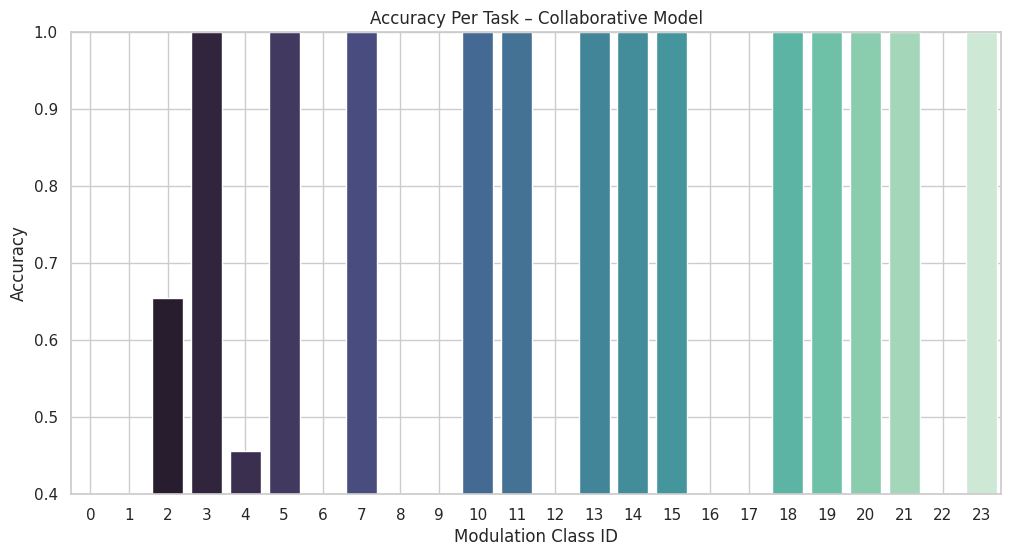

In [18]:
def evaluate_per_task(model, dataloader, num_tasks=24):
    model.eval()
    correct = [0] * num_tasks
    total = [0] * num_tasks

    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()

            for i in range(num_tasks):
                correct[i] += (preds[:, i] == Y_batch[:, i]).sum().item()
                total[i] += Y_batch.shape[0]  # one label per sample

    accuracies = [c / t if t > 0 else 0 for c, t in zip(correct, total)]
    return accuracies

# Evaluate collaborative model
collab_accuracies = evaluate_per_task(collab_model, test_loader)

# Plot
df = pd.DataFrame({
    'Task ID': list(range(24)),
    'Accuracy': collab_accuracies
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Task ID', y='Accuracy', palette='mako')
plt.title("Accuracy Per Task – Collaborative Model")
plt.xlabel("Modulation Class ID")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.show()


## Interference experiment
### Adding a new device with unseen classes and merging it into the collaborative model

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


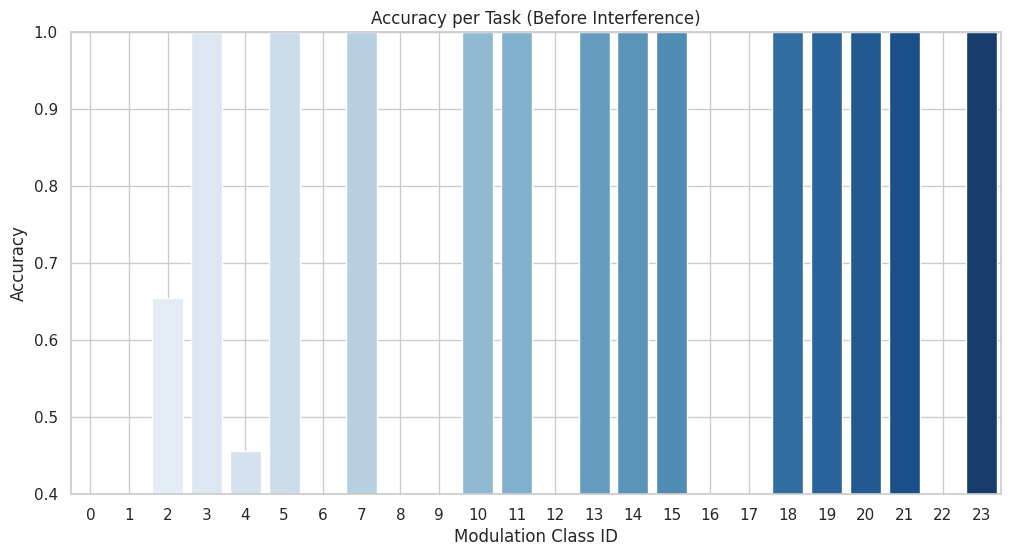

Available classes in Y_subset: [0 1 2]
Using NEW_CLASSES: [2, 0]
Capping new device samples from 193504 to 10000
New device has 10000 samples
🆕 New device training - Epoch 1 | Loss: 0.4441
🆕 New device training - Epoch 2 | Loss: 0.3161
🆕 New device training - Epoch 3 | Loss: 0.3027
🆕 New device training - Epoch 4 | Loss: 0.2903
🆕 New device training - Epoch 5 | Loss: 0.2786


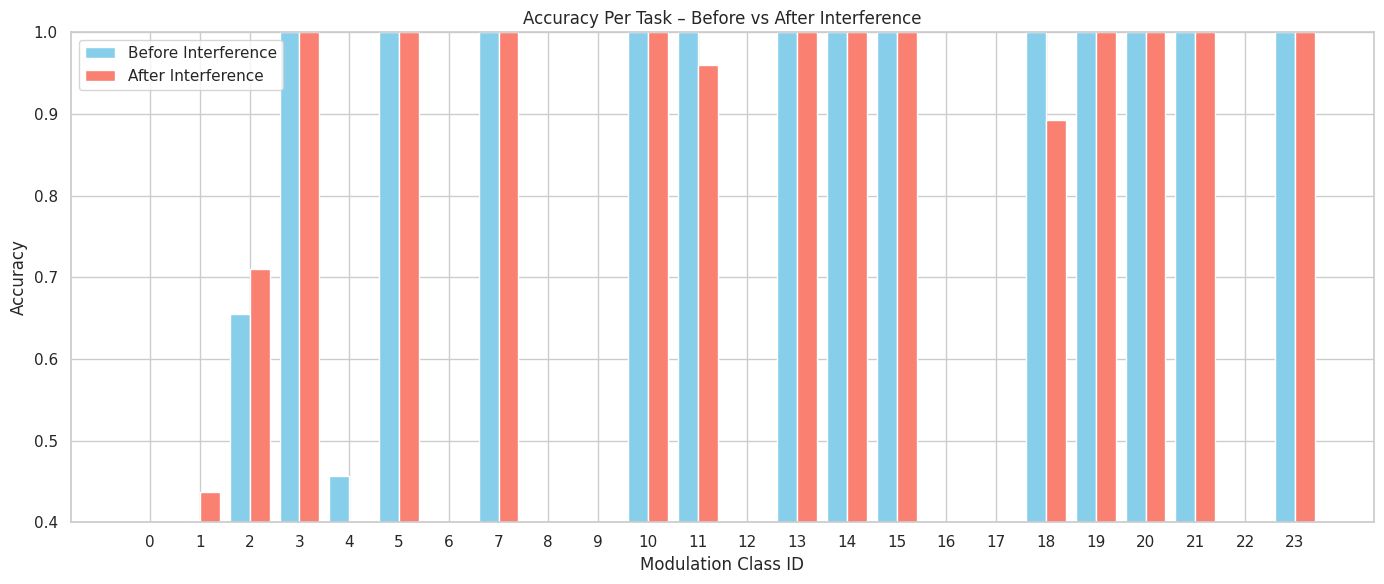

In [19]:
# STEP 1: Save baseline performance of current collaborative model
original_accuracies = evaluate_per_task(collab_model, test_loader)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict
plt.figure(figsize=(12, 6))
sns.barplot(x=list(range(24)), y=original_accuracies, palette='Blues')
plt.title("Accuracy per Task (Before Interference)")
plt.xlabel("Modulation Class ID")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.grid(True)
plt.show()

# STEP 2: Choose new modulation classes and collect data

y_subset_ids = np.argmax(Y_subset, axis=1)                                       # Check which classes are available in the current subset
available_classes, counts = np.unique(y_subset_ids, return_counts=True)
class_counts = dict(zip(available_classes, counts))
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1])

NEW_CLASSES = [cls for cls, _ in sorted_classes[:2]]                             # Pick least frequent classes to simulate new/rare task
print("Available classes in Y_subset:", available_classes)
print("Using NEW_CLASSES:", NEW_CLASSES)

new_device_data = [                                                              # Filter samples for these new classes
    (X_subset[i], Y_subset[i])
    for i in range(len(Y_subset))
    if np.argmax(Y_subset[i]) in NEW_CLASSES
]

MAX_NEW_SAMPLES = 10000                                                          # Cap new device sample count to prevent memory crash
if len(new_device_data) > MAX_NEW_SAMPLES:
    print(f"Capping new device samples from {len(new_device_data)} to {MAX_NEW_SAMPLES}")
    new_device_data = random.sample(new_device_data, MAX_NEW_SAMPLES)

print(f"New device has {len(new_device_data)} samples")

if len(new_device_data) < 100:
    raise ValueError("Not enough new device samples. Try different NEW_CLASSES.")

# STEP 3: Train a new device model on these classes
class NewDeviceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

random.shuffle(new_device_data)
split = int(0.8 * len(new_device_data))
train_data = new_device_data[:split]
val_data = new_device_data[split:]

new_train_loader = DataLoader(NewDeviceDataset(train_data), batch_size=128, shuffle=True)
new_val_loader = DataLoader(NewDeviceDataset(val_data), batch_size=128)

new_model = MultiTaskIQCNN(num_tasks=24).to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)

for epoch in range(5):                                                           # Train the new device
    new_model.train()
    total_loss = 0
    for X_batch, Y_batch in new_train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = new_model(X_batch)
        loss = masked_bce_loss(outputs, Y_batch, NEW_CLASSES)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    print(f"🆕 New device training - Epoch {epoch+1} | Loss: {total_loss / len(train_data):.4f}")

# STEP 4: Merge new model with collab_model
# 1. Merge shared layers
combined_shared = average_state_dicts([
    collab_model.shared.state_dict(),
    new_model.shared.state_dict()
])
collab_model.shared.load_state_dict(combined_shared)

# 2. Merge output heads only for NEW_CLASSES
existing_head_state = collab_model.head.state_dict()
new_head_state = new_model.head.state_dict()

for param_name in existing_head_state:
    for cls in NEW_CLASSES:
        if f".{cls}" in param_name:
            existing_head_state[param_name] = (
                existing_head_state[param_name] + new_head_state[param_name]
            ) / 2

collab_model.head.load_state_dict(existing_head_state)

# STEP 5: Re-evaluate collaborative model
updated_accuracies = evaluate_per_task(collab_model, test_loader)

plt.figure(figsize=(14, 6))                                                        # Compare before vs after interference
bar_width = 0.4
x = np.arange(24)

plt.bar(x - bar_width/2, original_accuracies, width=bar_width, label="Before Interference", color='skyblue')
plt.bar(x + bar_width/2, updated_accuracies, width=bar_width, label="After Interference", color='salmon')

plt.title("Accuracy Per Task – Before vs After Interference")
plt.xlabel("Modulation Class ID")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
